# Scibids 
## Case study

### Introduction

Scibids goal is to improve our client’s KPIs (CPA, CTR etc...) by bidding the best price
according to the probability of conversion of each auction.
The algorithm is using past data to learn the best contexts, each time a conversion is
happening, it knows which contexts are responsible for the conversion and uses this to
“learn” what are the best contexts to bid on

### Definitions

* **DSP (Demand Side Platform)**: An advertising purchase platform (also measures campaign results).
* **DCM (Double Click Campaign Manager)**: A third-party tool for measuring campaign results operated within the DSP.
* **Insertion Order**: An advertising campaign.
* **Line Item**: A targeting strategy within a campaign (multiple Line Items can exist per Insertion Order).
* **APP/URL**: The website or app where the banner ad was displayed.
* **Creative Size**: The dimensions of the displayed banner ads.
* **Creative ID**: The ID of the displayed banner ad.
* **Exchange**: An exchange platform in the middle of the buyer/seller chain.
* **Impression**: The number of times an ad was displayed.
* **Click Rate**: The number of clicks divided by the number of impressions.

$$
  \text{Click Rate} = \frac{\text{Number of Clicks}}{\text{Number of Impressions}}
$$

* **Post Click Conversions**: Conversions that occur after a user clicks on an ad.
* **Post View Conversions**: Conversions that occur after a user sees an ad (without clicking on it).
* **Floodlight**: A conversion pixel—if an event occurs, a conversion is attributed to the ad (e.g., a site visit, purchase, form submission, etc.).
* **Revenue**: The total of money spent on advertising + DSP fees + agency margin + other costs.
* **Mediacost**: Money invested in advertising.
* **Placement**: The name of the banner ad (DCM).
* **Package/Roadblock**: The name of the advertising targeting (DCM).
* **CPA (Cost Per Action)**: The cost per acquisition or action, which is the fee a company pays whenever an ad leads to a conversion.

$$
  CPA = \frac{\text{Total Cost}}{\text{Number of Conversions}}
$$

* **CTR (Clickthrough Rate)**: The number of clicks an ad receives divided by the number of times the ad is shown.

$$
  CTR = \frac{\text{Total Clicks}}{\text{Total Impressions}}
$$





###  Exercise

Scibids ran an A/B test for one of our clients.

* The test ran from July 1st - July 31st.
* The KPIs were landing page pixel loads (CPA based on DCM stats) and CTR.
* The client felt that due to the CTR performance of their IO they outperformed Scibids IO.
* The exercise is all based on the same data included in: AB_Test.xlsx

Our target is to present to our client the AB test to prove our value. For this our strategy
would be:

1) Defend AB test results and try to convince that Scibids did good and why
2) Find a way to estimate Scibids financial impact on this campaign

A valuable output is a “simple to understand” output with some clear key take-aways.


## Code

### Libraries used

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

### Reading datasets

Here we will read the excel sheets as pandas dataframes and determine their dimensions to see what we are working with.

In [2]:
# Read the data from the Excel file
dsp_data = pd.read_excel('AB_Test.xlsx', sheet_name='AB DSP Data Set')
dcm_data = pd.read_excel('AB_Test.xlsx', sheet_name='AB DCM Data Set')

# Examine the data
print("DSP Data Shape:", dsp_data.shape)
print("DCM Data Shape:", dcm_data.shape)

DSP Data Shape: (362976, 17)
DCM Data Shape: (578, 9)


### Data cleaning

Here we clean the dataframes and rename some columns to have an easier-to-work dataframe. We print the final columns and watch fro missing values.

In [3]:
# Function to clean column names
def clean_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace(':', '_').str.replace('-', '_')
    df['date'] = pd.to_datetime(df['date'])
    return df

# Clean column names
dsp_data = clean_column_names(dsp_data)
dcm_data = clean_column_names(dcm_data)

# Rename columns
dcm_data = dcm_data.rename(columns={
    'remarketing___sitewide_remarketing__click_through_conversions': 'post_click_floodlight',
    'remarketing___sitewide_remarketing__view_through_conversions': 'post_view_floodlight',
    'remarketing___sitewide_remarketing__total_conversions': 'total_conversions_floodlight'
})

# Columns in each dataset
print("\nDSP Data Columns:", dsp_data.columns.tolist())
print("\nDCM Data Columns:", dcm_data.columns.tolist())

# Check for missing values
print("\nMissing values in DSP data:")
print(dsp_data.isnull().sum())
print("\nMissing values in DCM data:")
print(dcm_data.isnull().sum())


DSP Data Columns: ['insertion_order', 'line_item', 'date', 'app/url', 'creative_size', 'creative_id', 'device_type', 'exchange', 'floodlight_activity_name', 'impressions', 'clicks', 'click_rate_ctr', 'total_conversions', 'post_click_conversions', 'post_view_conversions', 'revenue_adv_currency', 'media_cost_advertiser_currency']

DCM Data Columns: ['placement', 'date', 'line_item', 'month', 'impressions', 'clicks', 'post_click_floodlight', 'post_view_floodlight', 'total_conversions_floodlight']

Missing values in DSP data:
insertion_order                   0
line_item                         0
date                              0
app/url                           0
creative_size                     0
creative_id                       0
device_type                       0
exchange                          0
floodlight_activity_name          0
impressions                       0
clicks                            0
click_rate_ctr                    0
total_conversions                 0
pos

No missing values, so we are good to go.

### IO and line item identification

Here we find the unique IO's one of the client and the other of Scibids to later compare their respective performances.

In [4]:
# Identify IOs to compare Scibids vs Client
io_list = dsp_data['insertion_order'].unique()
print("\nInsertion Orders (IOs):", io_list)

scibids_io = io_list[1]
client_io = io_list[0]

print(f"Scibids IO identified: {scibids_io}")
print(f"Client IO identified: {client_io}")

# Examine line items to verify our IO identification
scibids_line_items = dsp_data[dsp_data['insertion_order'] == scibids_io]['line_item'].unique()
client_line_items = dsp_data[dsp_data['insertion_order'] == client_io]['line_item'].unique()

print("\nScibids Line Items:", scibids_line_items)
print("Client Line Items:", client_line_items)



Insertion Orders (IOs): ['Display_US_DV360_WK21_TNT_PROSP_Banners_Brand'
 'Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_SciBids']
Scibids IO identified: Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_SciBids
Client IO identified: Display_US_DV360_WK21_TNT_PROSP_Banners_Brand



Scibids Line Items: ['Display_US_DV360_WK21_TNT_PROSP_Banner_Affinity_SciBids'
 'Display_US_DV360_WK21_TNT_PROSP_Banner_InMarketShoes_SciBids'
 'Display_US_DV360_WK21_TNT_PROSP_Banner_KeywordsBrand_SciBids']
Client Line Items: ['Display_US_DV360_WK21_TNT_PROSP_Banner_Affinity'
 'Display_US_DV360_WK21_TNT_PROSP_Banner_InMarketShoes'
 'Display_US_DV360_WK21_TNT_PROSP_Banner_KeywordsBrand']


### Daily KPIs

Here we calculate some useful daily KPIs to measure IO performance, in this case, the Click Through Rate (CTR) and Cost Per Acquisition (CPA).

In [5]:
# DSP data by IO and date to check daily performance
daily_dsp = dsp_data.groupby(['insertion_order', 'date']).agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'media_cost_advertiser_currency': 'sum',
    'total_conversions': 'sum',
    'post_click_conversions': 'sum',
    'post_view_conversions': 'sum'
}).reset_index()

# CTR for DSP data
daily_dsp['ctr'] = daily_dsp['clicks'] / daily_dsp['impressions']
daily_dsp['cpa'] = daily_dsp['media_cost_advertiser_currency'] / daily_dsp['total_conversions']

# Potential NaN values in CPA 
daily_dsp['cpa'] = daily_dsp['cpa'].replace([np.inf, -np.inf], np.nan)

display(daily_dsp.head())

,insertion_order,date,impressions,clicks,media_cost_advertiser_currency,total_conversions,post_click_conversions,post_view_conversions,ctr,cpa
0,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-01,28677,179,173.090589,306,9,297,0.006242,0.565656
1,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-02,55035,354,370.168677,237,22,215,0.006432,1.561893
2,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-03,51788,375,339.523239,419,74,345,0.007241,0.810318
3,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-04,61213,443,367.298017,329,27,302,0.007237,1.116407
4,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-05,61846,380,367.064033,408,43,365,0.006144,0.899667


Here we create a new column in DCM dataframe mapping the line_item column to a IO for a posterior merge, also calculating the daily CTR in the DCM dataframe.

In [6]:
# Group DCM data by placement and date
# Mapping from line_item to insertion_order using DSP data
line_to_io = dsp_data[['line_item', 'insertion_order']].drop_duplicates().set_index('line_item')['insertion_order'].to_dict()

# Map DCM line items to insertion orders
dcm_data['insertion_order'] = dcm_data['line_item'].map(line_to_io)

# If there is any unmapped line items, we check if 'scibids' is in the line item name
for idx, row in dcm_data[dcm_data['insertion_order'].isna()].iterrows():
    line_item = str(row['line_item']).lower()
    if any(keyword in line_item for keyword in ['Scibids', 'scibids']):
        dcm_data.loc[idx, 'insertion_order'] = scibids_io
    else:
        dcm_data.loc[idx, 'insertion_order'] = client_io

# Group DCM data by IO and date
daily_dcm = dcm_data.groupby(['insertion_order', 'date']).agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'post_click_floodlight': 'sum',
    'post_view_floodlight': 'sum',
    'total_conversions_floodlight': 'sum',
}).reset_index()

# Calculate CTR for DCM data
daily_dcm['ctr'] = daily_dcm['clicks'] / daily_dcm['impressions'] 

display(daily_dcm)

,insertion_order,date,impressions,clicks,post_click_floodlight,post_view_floodlight,total_conversions_floodlight,ctr
0,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-01,58405,389,124,578,702,0.006660
1,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-02,111149,727,218,853,1071,0.006541
2,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-03,104690,762,326,689,1015,0.007279
3,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-04,122886,888,255,682,937,0.007226
4,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-05,123998,737,229,677,906,0.005944
...,...,...,...,...,...,...,...,...
59,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-28,224052,747,396,343,739,0.003334
60,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-29,221585,704,416,409,825,0.003177
61,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-30,207371,620,345,152,497,0.002990
62,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-31,206316,707,362,163,525,0.003427


In [11]:
display(daily_dsp)

,insertion_order,date,impressions,clicks,media_cost_advertiser_currency,total_conversions,post_click_conversions,post_view_conversions,ctr,cpa
0,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-01,28677,179,173.090589,306,9,297,0.006242,0.565656
1,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-02,55035,354,370.168677,237,22,215,0.006432,1.561893
2,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-03,51788,375,339.523239,419,74,345,0.007241,0.810318
3,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-04,61213,443,367.298017,329,27,302,0.007237,1.116407
4,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-05,61846,380,367.064033,408,43,365,0.006144,0.899667
...,...,...,...,...,...,...,...,...,...,...
57,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-27,236278,719,315.499931,355,15,340,0.003043,0.888732
58,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-28,237727,679,285.521893,207,17,190,0.002856,1.379333
59,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-29,233511,667,320.100655,381,15,366,0.002856,0.840159
60,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-30,217814,603,336.036235,407,11,396,0.002768,0.825642


We calculated the CTR in each table, this could be a problem if the values calculated in each table were different, but they're near the same, so we can continue.

### Merging daily DCM and DSP

Here we merge both dataframes on date and IO to compare performances.

In [7]:
# Merge DSP and DCM data for comprehensive analysis
merged_daily = pd.merge(
    daily_dsp[['insertion_order', 'date', 'impressions', 'clicks', 'media_cost_advertiser_currency', 'ctr']], 
    daily_dcm[['insertion_order', 'date', 'post_click_floodlight', 'post_view_floodlight', 'total_conversions_floodlight']], 
    on=['insertion_order', 'date'], 
    how='outer'
)

# NaN values
merged_daily = merged_daily.fillna(0)

# CPA using DCM conversions and DSP costs
merged_daily['cpa'] = merged_daily['media_cost_advertiser_currency'] / merged_daily['total_conversions_floodlight'].replace(0, np.nan)
merged_daily['cpa'] = merged_daily['cpa'].replace([np.inf, -np.inf], np.nan)

display(merged_daily)

,insertion_order,date,impressions,clicks,media_cost_advertiser_currency,ctr,post_click_floodlight,post_view_floodlight,total_conversions_floodlight,cpa
0,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-01,28677.0,179.0,173.090589,0.006242,124,578,702,0.246568
1,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-02,55035.0,354.0,370.168677,0.006432,218,853,1071,0.345629
2,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-03,51788.0,375.0,339.523239,0.007241,326,689,1015,0.334506
3,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-04,61213.0,443.0,367.298017,0.007237,255,682,937,0.391994
4,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2021-07-05,61846.0,380.0,367.064033,0.006144,229,677,906,0.405148
...,...,...,...,...,...,...,...,...,...,...
59,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-28,237727.0,679.0,285.521893,0.002856,396,343,739,0.386363
60,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-29,233511.0,667.0,320.100655,0.002856,416,409,825,0.388001
61,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-30,217814.0,603.0,336.036235,0.002768,345,152,497,0.676129
62,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,2021-07-31,217679.0,664.0,336.139758,0.003050,362,163,525,0.640266


### IO Comparison (Smaller CPR, but also smaller CPA)

Here we group the merged dataframe by the IO to compare the overall performances:

In [8]:
# Performance metrics aggregation
overall_performance = merged_daily.groupby('insertion_order').agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'media_cost_advertiser_currency': 'sum',
    'post_click_floodlight': 'sum',
    'post_view_floodlight': 'sum',
    'total_conversions_floodlight': 'sum'
}).reset_index()

# Overall CTR and CPA
overall_performance['ctr'] = overall_performance['clicks'] / overall_performance['impressions'] * 100
overall_performance['cpa'] = overall_performance['media_cost_advertiser_currency'] / overall_performance['total_conversions_floodlight']

display(overall_performance)

print("\nOverall Performance:")
print(overall_performance)

# Performance difference (% improvement by Scibids over Client)
scibids_metrics = overall_performance[overall_performance['insertion_order'] == scibids_io].iloc[0]
client_metrics = overall_performance[overall_performance['insertion_order'] == client_io].iloc[0]

improvement = {
    'ctr': (scibids_metrics['ctr'] - client_metrics['ctr']) / client_metrics['ctr'] * 100,
    'cpa': (-scibids_metrics['cpa'] + client_metrics['cpa']) / client_metrics['cpa'] * 100  # Reversed because lower CPA is better
}

print(f"\nCTR Improvement: {improvement['ctr']:.2f}%")
print(f"CPA Improvement: {improvement['cpa']:.2f}%")

,insertion_order,impressions,clicks,media_cost_advertiser_currency,post_click_floodlight,post_view_floodlight,total_conversions_floodlight,ctr,cpa
0,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand,2046269.0,13599.0,11019.071091,8491,14895,23386,0.664575,0.471182
1,Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...,5304097.0,19868.0,9067.627821,11897,14663,26560,0.374578,0.341402



Overall Performance:
                                     insertion_order  impressions   clicks  \
0      Display_US_DV360_WK21_TNT_PROSP_Banners_Brand    2046269.0  13599.0   
1  Display_US_DV360_WK21_TNT_PROSP_Banners_Brand_...    5304097.0  19868.0   

   media_cost_advertiser_currency  post_click_floodlight  \
0                    11019.071091                   8491   
1                     9067.627821                  11897   

   post_view_floodlight  total_conversions_floodlight       ctr       cpa  
0                 14895                         23386  0.664575  0.471182  
1                 14663                         26560  0.374578  0.341402  

CTR Improvement: -43.64%
CPA Improvement: 27.54%


We see that Scibids does worse in Click Through Rate, that might make us think that the Client IO did better, but as we can see the Cost Per Action is much smaller with Scibids IO. We will investigate further:

### Financial impact

Since we calculated the CPA from each IO we can compare their performances conversions and potential savings:

In [ ]:
# Potential savings if the entire budget was allocated to Scibids
total_budget = overall_performance['media_cost_advertiser_currency'].sum()
scibids_cpa = scibids_metrics['cpa']
client_cpa = client_metrics['cpa']

# Conversions if all budget was allocated to Scibids vs Client
potential_conversions_scibids = total_budget / scibids_cpa
potential_conversions_client = total_budget / client_cpa

additional_conversions = potential_conversions_scibids - potential_conversions_client
conversion_improvement_percent = (additional_conversions / potential_conversions_client) * 100

print(f"\nFinancial Impact Analysis")
print(f"Total campaign budget: ${total_budget:.2f}")
print(f"Estimated conversions with Scibids (full budget): {potential_conversions_scibids:.2f}")
print(f"Estimated conversions with Client approach (full budget): {potential_conversions_client:.2f}")
print(f"Additional conversions with Scibids: {additional_conversions:.2f} ({conversion_improvement_percent:.2f}%)")

# Budget savings for the same number of conversions
target_conversions = overall_performance['total_conversions_floodlight'].sum()
budget_with_scibids = target_conversions * scibids_cpa
budget_with_client = target_conversions * client_cpa
budget_savings = budget_with_client - budget_with_scibids
budget_savings_percent = (budget_savings / budget_with_client) * 100

print(f"\nFor {target_conversions:.0f} conversions:")
print(f"Budget needed with Scibids: ${budget_with_scibids:.2f}")
print(f"Budget needed with Client approach: ${budget_with_client:.2f}")
print(f"Budget savings with Scibids: ${budget_savings:.2f} ({budget_savings_percent:.2f}%)")


Financial Impact Analysis ---
Total campaign budget: $20086.70
Estimated conversions with Scibids (full budget): 58835.97
Estimated conversions with Client approach (full budget): 42630.41
Additional conversions with Scibids: 16205.56 (38.01%)

For 49946 conversions:
Budget needed with Scibids: $17051.65
Budget needed with Client approach: $23533.68
Budget savings with Scibids: $6482.03 (27.54%)


Now we will visualize our findings:

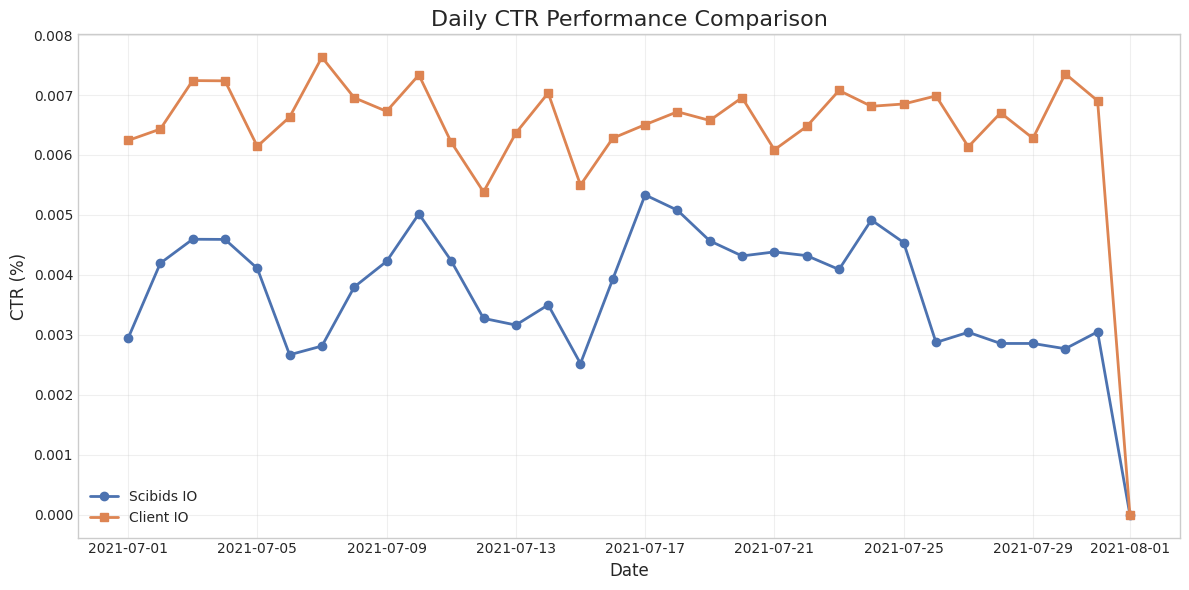

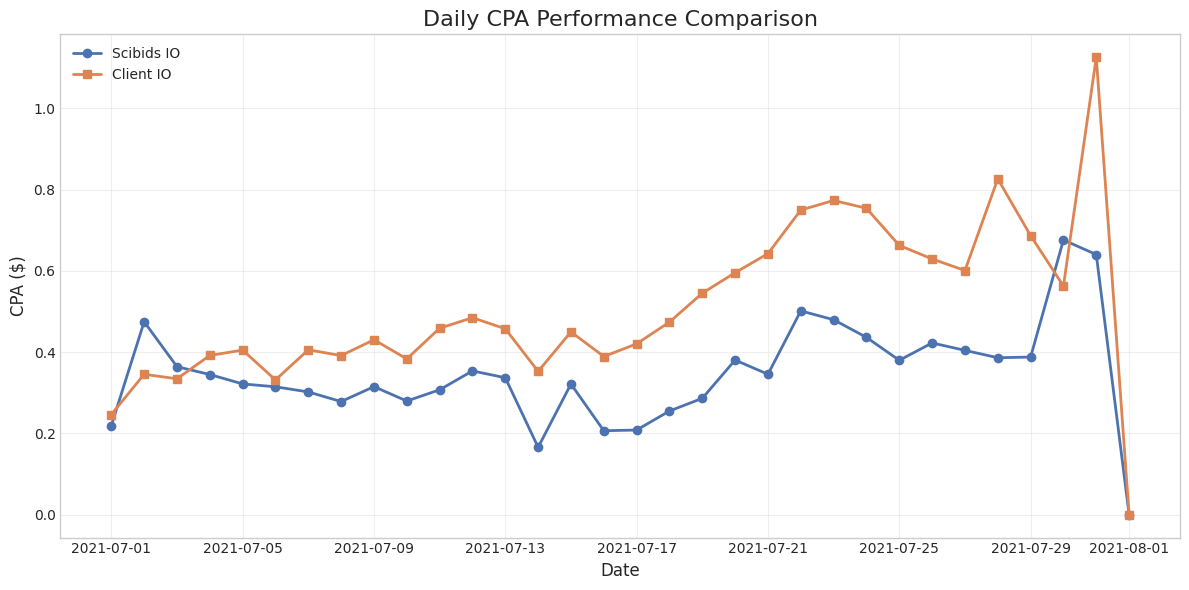

In [17]:
# Time series of daily CTR
plt.figure(figsize=(12, 6))
scibids_daily = merged_daily[merged_daily['insertion_order'] == scibids_io]
client_daily = merged_daily[merged_daily['insertion_order'] == client_io]

plt.plot(scibids_daily['date'], scibids_daily['ctr'], label=f'Scibids IO', marker='o', linewidth=2)
plt.plot(client_daily['date'], client_daily['ctr'], label=f'Client IO', marker='s', linewidth=2)

plt.title('Daily CTR Performance Comparison', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CTR (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('daily_ctr_comparison.png', dpi=300)

# Time series of daily CPA 
plt.figure(figsize=(12, 6))
scibids_daily_with_conv = scibids_daily[~scibids_daily['cpa'].isna()]
client_daily_with_conv = client_daily[~client_daily['cpa'].isna()]

plt.plot(scibids_daily_with_conv['date'], scibids_daily_with_conv['cpa'], label=f'Scibids IO', marker='o', linewidth=2)
plt.plot(client_daily_with_conv['date'], client_daily_with_conv['cpa'], label=f'Client IO', marker='s', linewidth=2)

plt.title('Daily CPA Performance Comparison', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CPA ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('daily_cpa_comparison.png', dpi=300)
plt.show()

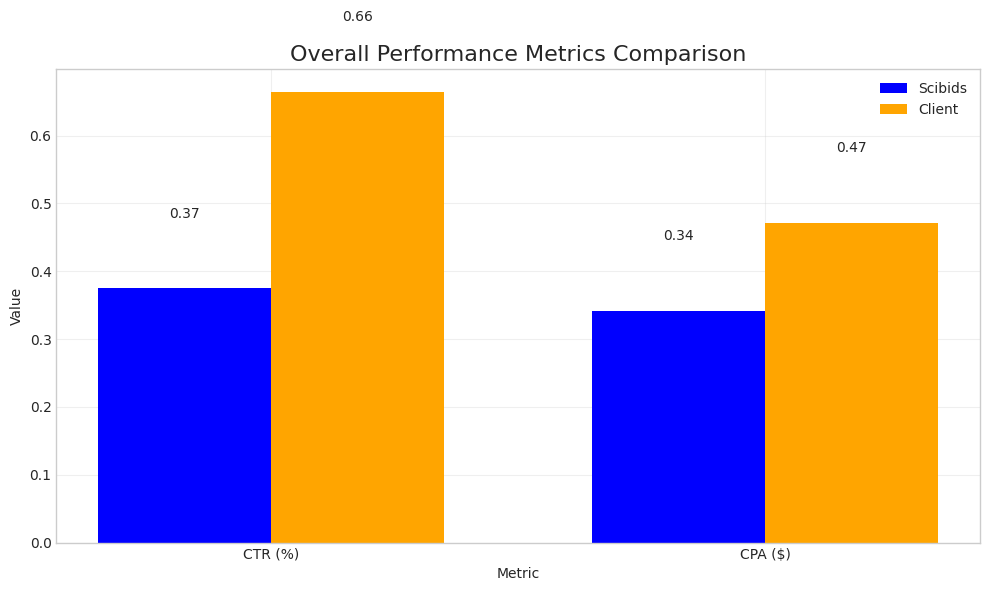

In [18]:
metrics_comparison = pd.DataFrame({
    'Metric': ['CTR (%)', 'CPA ($)'],
    'Scibids': [scibids_metrics['ctr'], scibids_metrics['cpa']],
    'Client': [client_metrics['ctr'], client_metrics['cpa']]
})

metrics_comparison_melted = pd.melt(metrics_comparison, id_vars=['Metric'], var_name='IO', value_name='Value')

plt.figure(figsize=(10, 6))

x = range(len(metrics_comparison['Metric']))
bar_width = 0.35

plt.bar([i - bar_width/2 for i in x], metrics_comparison['Scibids'], width=bar_width, label='Scibids', color='blue')
plt.bar([i + bar_width/2 for i in x], metrics_comparison['Client'], width=bar_width, label='Client', color='orange')

# Label the bars
for i, (scibids_val, client_val) in enumerate(zip(metrics_comparison['Scibids'], metrics_comparison['Client'])):
    plt.text(i - bar_width/2, scibids_val + 0.1, f'{scibids_val:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(i + bar_width/2, client_val + 0.1, f'{client_val:.2f}', ha='center', va='bottom', fontsize=10)

plt.xticks(x, metrics_comparison['Metric'])
plt.title('Overall Performance Metrics Comparison', fontsize=16)
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('overall_metrics_comparison_plt.png', dpi=300)

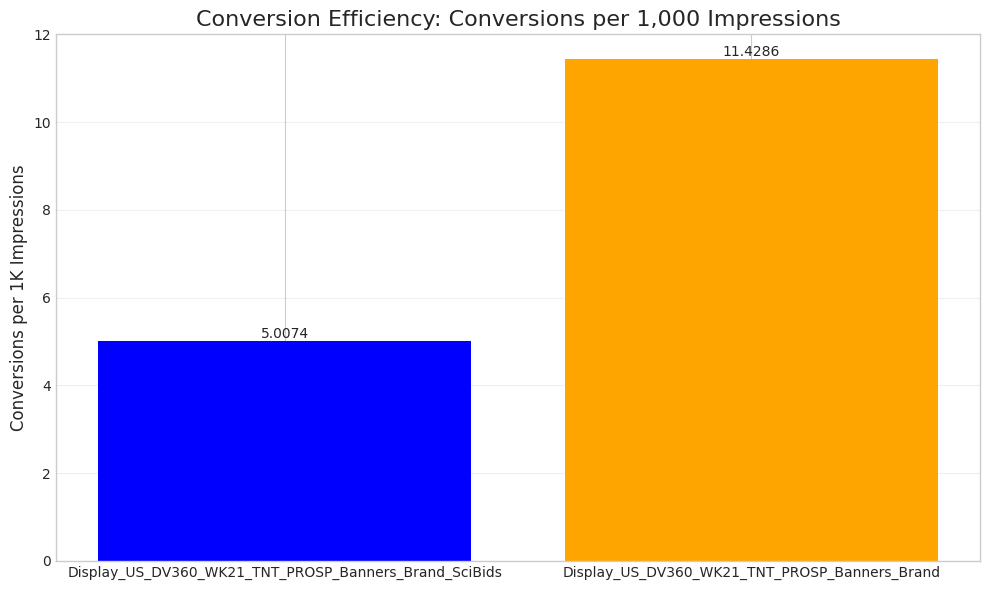

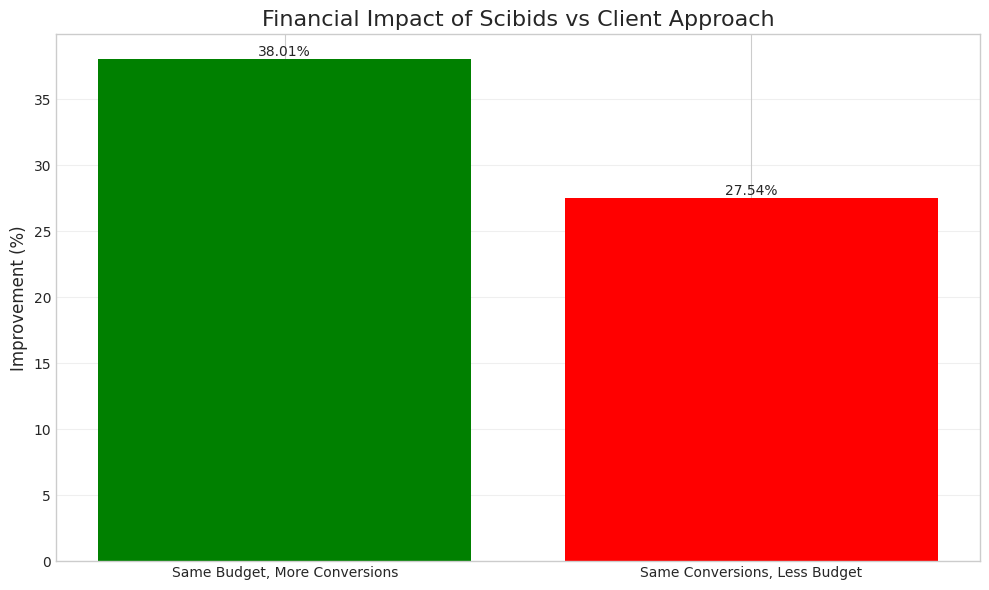

In [19]:
# Calculate conversions per 1000 impressions
overall_performance['conversions_per_1k_impressions'] = (
    overall_performance['total_conversions_floodlight'] / overall_performance['impressions'] * 1000
)

conv_efficiency = pd.DataFrame({
    'IO': [scibids_io, client_io],
    'Conversions per 1K Impressions': [
        overall_performance[overall_performance['insertion_order'] == scibids_io]['conversions_per_1k_impressions'].values[0],
        overall_performance[overall_performance['insertion_order'] == client_io]['conversions_per_1k_impressions'].values[0]
    ]
})

plt.figure(figsize=(10, 6))
bars = plt.bar(conv_efficiency['IO'], conv_efficiency['Conversions per 1K Impressions'], color=['blue', 'orange'])

# Labels on bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.4f}',
             ha='center', va='bottom', fontsize=10)

plt.title('Conversion Efficiency: Conversions per 1,000 Impressions', fontsize=16)
plt.ylabel('Conversions per 1K Impressions', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('conversion_efficiency.png', dpi=300)

# Financial impact visualization
financial_impact = pd.DataFrame({
    'Scenario': ['Same Budget, More Conversions', 'Same Conversions, Less Budget'],
    'Improvement': [conversion_improvement_percent, budget_savings_percent]
})

plt.figure(figsize=(10, 6))
bars = plt.bar(financial_impact['Scenario'], financial_impact['Improvement'], color=['green', 'red'])

# Labels on bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}%',
             ha='center', va='bottom', fontsize=10)

plt.title('Financial Impact of Scibids vs Client Approach', fontsize=16)
plt.ylabel('Improvement (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('financial_impact.png', dpi=300)

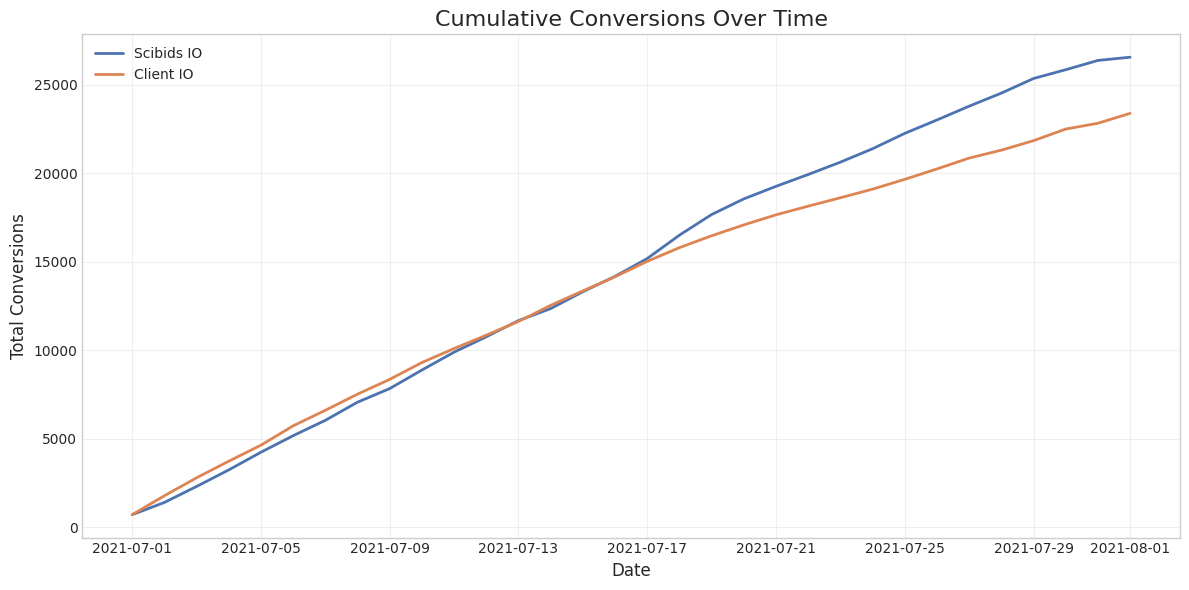

In [20]:
# Cumulative conversions over time
scibids_daily_sorted = scibids_daily.sort_values('date')
client_daily_sorted = client_daily.sort_values('date')

scibids_daily_sorted['cumulative_conversions'] = scibids_daily_sorted['total_conversions_floodlight'].cumsum()
client_daily_sorted['cumulative_conversions'] = client_daily_sorted['total_conversions_floodlight'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(scibids_daily_sorted['date'], scibids_daily_sorted['cumulative_conversions'], 
         label=f'Scibids IO', linewidth=2)
plt.plot(client_daily_sorted['date'], client_daily_sorted['cumulative_conversions'], 
         label=f'Client IO', linewidth=2)

plt.title('Cumulative Conversions Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Conversions', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('cumulative_conversions.png', dpi=300)